# ELG7186 - fall 2022 - Assignment 1
## Due: <strong>Wednesday Oct. 12<sup>th</sup> 2022 -- 11:59pm</strong>

The purpose of this assignment is to gain some experience working with the tools you will use throughout the course. You will learn:
- The basics of data loading and preparation
- Classification using the k-NN algorithm
- Classification using a Support Vector Machine (SVM)
- Calculation of metrics to assess the performance of your model

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you will submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


In [1]:
import skimage
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
from scipy import stats as st
import tqdm.notebook
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import time



In [2]:
def plot_confusionMatrix(y, y_pred, title=''):
    cm = confusion_matrix(y, y_pred)
    
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='BuGn')
    disp.ax_.set_title(title)

## Part 0. Dataset Preparation
To complete the assignment you will need to download the Cifar10 dataset and devise an appropriate training set split. You may acquire the dataset using the method of your choice. Note that some sources e.g. sklearn have reduced the samples to only 1797 (this could negatively affect your results). If you use the full dataset, you are free to sample from the dataset to reduce the overal training samples. The overall accuracy is less important than your  observations and comparisons. For example classifying the full 10,000 test images might take approximately 15 minutes using k-NN.

In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Divide the raw data into appropriate training and test sets for both the images and corresponding labels for use with the subsequent parts of the assignment.</li>
<li>Visualize five samples of each class by plotting a grid using the matplotlib library.</li>
</ul>


### Loading Data

In [4]:
# Prepare your dataset here and display samples here.
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
        
        x = data[b'data']
        x= x.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)

        y = np.array(data[b'labels'])
    return x, y

def load_data(dir):
  files = glob.glob(f"{dir}_batch*")
  X = []
  Y = []
  for file in files:
    x, y = unpickle(file)
    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)


In [5]:
# Train data
X, Y= load_data(dir = 'data')
X = X.reshape(50000, 32, 32, 3)
Y = Y.reshape(50000, )

# Test data
X_test, Y_test = load_data(dir = 'test')
X_test = X_test.reshape(10000, 32, 32, 3)
Y_test = Y_test.reshape(10000, )

# check the shape
print(X.shape, Y.shape, "\n", X_test.shape, Y_test.shape)

(50000, 32, 32, 3) (50000,) 
 (10000, 32, 32, 3) (10000,)


In [6]:
'''
Sampling to reduce training time
Train : 10,000
Test: 1000
'''

np.random.seed(0)

# training sampling
smaples_indx = np.random.choice(X.shape[0], size=10000, replace=False)
x_sample = X[smaples_indx]
y_sample = Y[smaples_indx]


# test sampling
smaples_indx = np.random.choice(X_test.shape[0], size=1000, replace=False)
x_test_sample = X_test[smaples_indx]
y_test_sample = Y_test[smaples_indx]

In [7]:
# to make sure that data is still balanced after sampling
print(np.bincount(y_test_sample))
print(np.bincount(y_sample))

[ 90 115  94 105 103 105  87  89 103 109]
[1004  986 1016 1030  967 1016  953  999  989 1040]


### Visualizing

In [12]:
# Your code here
random.seed(0) # set a seed in case you want your experiments to be consistent

def draw_func(list_of_imgs):

  fig = plt.figure(figsize=(15, 10))
  rows = 1
  columns = 5

  samples = random.sample(list_of_imgs, rows*columns)
  for i, img in enumerate(samples):
    # Adding a subplot
    fig.add_subplot(rows, columns, i+1)
      
    # showing image
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(f"Image {i+1}")

  plt.show()

Label(0)


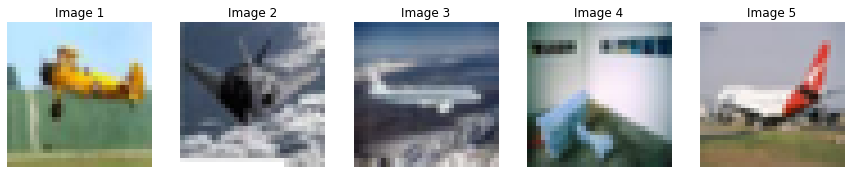

Label(1)


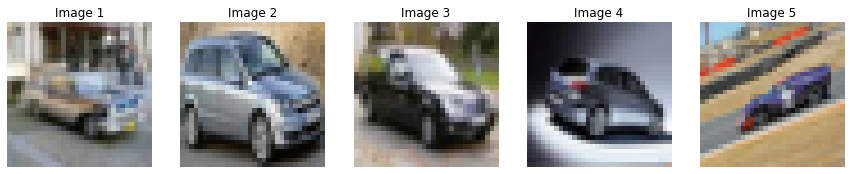

Label(2)


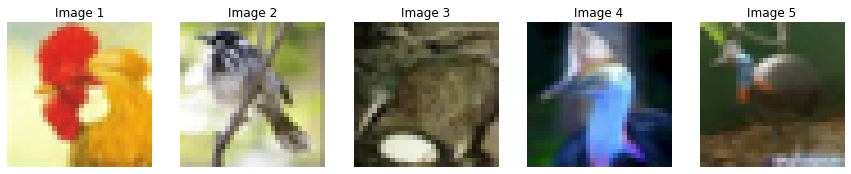

Label(3)


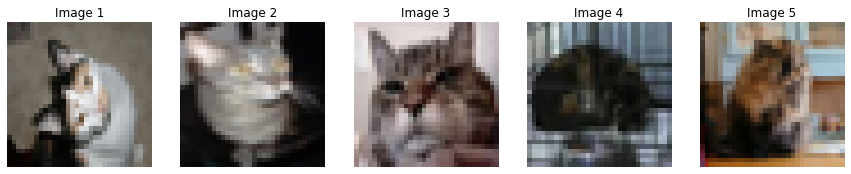

Label(4)


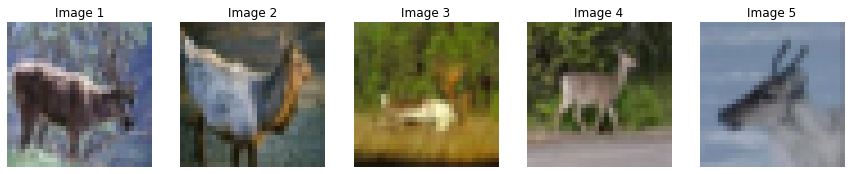

Label(5)


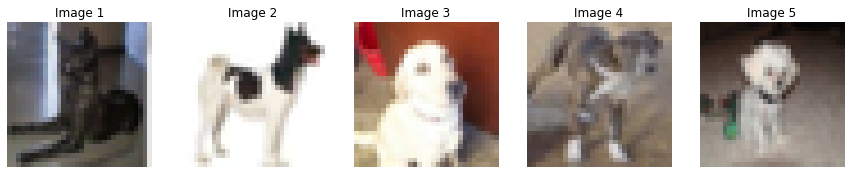

Label(6)


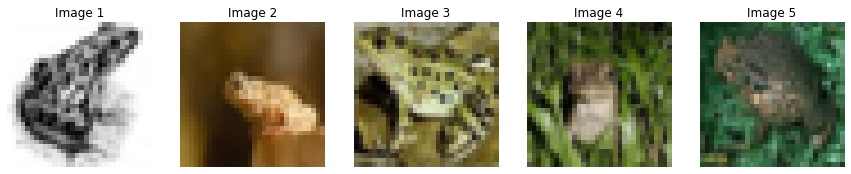

Label(7)


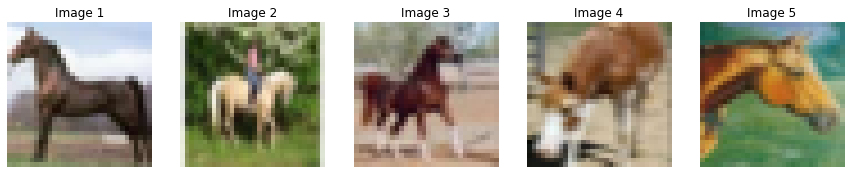

Label(8)


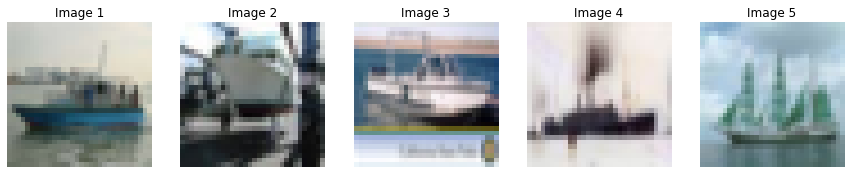

Label(9)


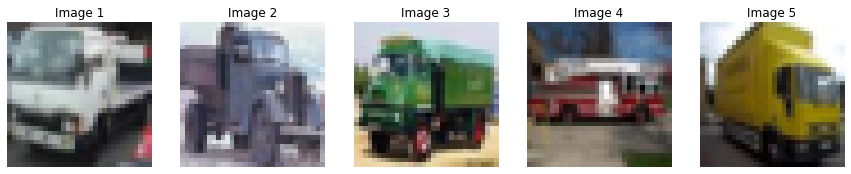

In [13]:
# Visualizing
for label in np.unique(Y_test):
  print(f"Label({label})")
  list_of_imgs = list(X[Y == label])
  draw_func(list_of_imgs)

## Part 1. k-NN Classifier (2 Marks)
For this section you will implement a simple kNN Classifier on the Cifar10 dataset. To do this you will need to perform the following steps:
- Create a k-NN class. Your class must contain a method that returns predictions for your test set.
- Provide a suitable distance metric that you will use to calculate the nearest neightbours. You may choose the distance metric you believe is most suitable.
- Calculate the k nearest neighbours and make predictions.
- Choose the a value for _k_ that results in the highest accuracy on your test set. Show how you found this value.

When your classifier is working:
- Use sklearn to calculate accuracy and plot a confusion matrix using your predictions.
- Provide a brief discussion of your results

### Bonus:

When you compute the distance metric you can acheive better performance if you vectorize the computation instead of using for loops to iterate through the values. You can earn __0.5 bonus marks__ if you only need one loop, or __1 bonus mark__ if you can omit for loops for a fully vectorized distance calculation (a maximum of 1 bonus mark is available).




In [8]:
## KNN class
class KNN():

    def __init__(self, k, d):
        self.k = k
        self.d = d

    def distance(self, x1, x2):
      if self.d == 'e':
        return np.sqrt(np.sum((x1[:x1.shape[0], None] - x2)**2, axis = 2))
      elif self.d == 'm':
        return np.sum(np.abs(x1[:x1.shape[0], None] - x2), axis = 2)

    def fit(self, X, y):
        self.X_train = X.reshape((X.shape[0], -1))
        self.y_train = y

    def predict(self, X_test):
        X_test = X_test.reshape((X_test.shape[0], -1))
        y_pred = [self._predict(x_test) for x_test in tqdm.notebook.tqdm(X_test)]
        return np.array(y_pred).flatten()

    def _predict(self, x_test):
        # Compute distances between x and the training set points
        distances = [self.distance(self.X_train, x_test)]
        distances = np.array(distances).flatten()

        # Return k nearest neighbors
        k_idx = np.argsort(distances)[:self.k] # get indexes
        k_neighbor_labels = self.y_train[k_idx] # get the labels

        # return the most common class label
        mode = st.mode(k_neighbor_labels)
        return mode[0]

In [15]:
'''
To get rid of the for loop, the following distance function could be used,
however, it crashes the available memory with more smaples
'''
def full_distance(x1, x2, d):
      '''
      input: x -> train data
             x_test -> test data
             d -> distance metric
      '''
      if d == 'e':
        return np.sqrt(np.sum((x1[:x1.shape[0], None] - x2)**2, axis = 2))
      elif d == 'm':
        return np.sum(np.abs(x1[:x1.shape[0], None] - x2), axis = 2)


#Calculate the distances between 10 test samples and 50,000 training points
full_distance(X[:5000].reshape(5000, -1), X_test[:100].reshape(100, -1), 'm').shape

(5000, 100)

In [22]:
#expriment function

def k_expriments (d = 'm'):
  '''
  Input: distance measur
  Output: K VS Accuracy 
          & confusion matrix for the highest accuracy prediction
  '''
  max_ = 0
  accuracies = []
  for k in [10, 50, 100, 323, 500]:
    knn_model = KNN(k = k, d = d)
    knn_model.fit(X, Y)
    Y_pred = knn_model.predict(x_test_sample)

    a = accuracy_score(y_test_sample, Y_pred)
    if a > max_:
      max_ = a
      y_pred_max = Y_pred
    print("K=",k," Accuracy=",a)
    accuracies.append(a)

  plot_confusionMatrix(y_test_sample, y_pred_max, title='KNN Confusion matrix')

  0%|          | 0/1000 [00:00<?, ?it/s]

K= 10  Accuracy= 0.234


  0%|          | 0/1000 [00:00<?, ?it/s]

K= 50  Accuracy= 0.222


  0%|          | 0/1000 [00:00<?, ?it/s]

K= 100  Accuracy= 0.229


  0%|          | 0/1000 [00:00<?, ?it/s]

K= 323  Accuracy= 0.212


  0%|          | 0/1000 [00:00<?, ?it/s]

K= 500  Accuracy= 0.2


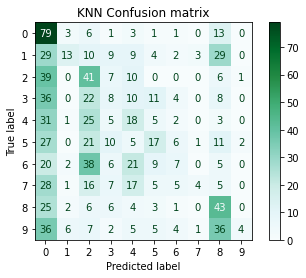

In [23]:
# Menhatten expriment:
k_expriments(d = 'm')

  0%|          | 0/1000 [00:00<?, ?it/s]

K= 10  Accuracy= 0.219


  0%|          | 0/1000 [00:00<?, ?it/s]

K= 50  Accuracy= 0.236


  0%|          | 0/1000 [00:00<?, ?it/s]

K= 100  Accuracy= 0.214


  0%|          | 0/1000 [00:00<?, ?it/s]

K= 323  Accuracy= 0.226


  0%|          | 0/1000 [00:00<?, ?it/s]

K= 500  Accuracy= 0.23


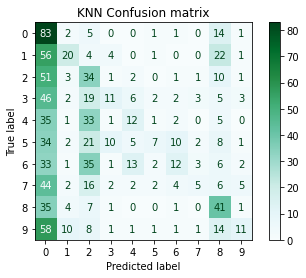

In [25]:
#Eulidean expriment
k_expriments(d = 'e')

**Discussion**


1.   Distance
  *   Accuracies are almost the same
  *   Before applying vectorization, Euclidean distance took longer time than Manhatten
  *   Both of the models are biased to the first class.


## Part 2. Logistic Regression (3 Marks)

For this section you will perform binary classification using logistic regression. Just as in Part 1. you will use the Cifar10 dataset, however to obtain a result for each class using logistic regression you will need to use a One-vs-Rest (OvR) approach to acheive multi-class classification.

Using ```LogisticRegression()``` in sklearn, write a function to execute the OvR strategy for the Cifar10 classes. Do not use the built-in ```OneVsResClassifier()``` method. You will need to follow these basic steps:
- Train a binary classifier for each class, where the target class is a "positive" results and the combination of the remaining classes are "negative". For Cifar10 you will need 10 models.
- For each test sample compute the probabilities for each model
- Select the argmax of the probabilities to obtain the predicted class

Collect your predictions from the test set and compute the accuracy score and plot a confusion matrix.

In [8]:
def ovr_encoder(y, label):
    new_y = np.copy(y)
    new_y[y == label] = 1
    new_y[y != label] = 0
    return new_y

In [9]:
t =time.time()

from sklearn.linear_model import LogisticRegression
p = [] #to store probabilities

for label in np.unique(y_sample):
  #Encoding the labels
  y_ovr_train = ovr_encoder(y_sample, label)
  #y_ovr_test = ovr_encoder(y_test_sample, label)

  # Train the model and calculate probabilities
  clf = LogisticRegression(random_state=0, max_iter = 2000).fit(x_sample.reshape(10000, -1)/255, y_ovr_train)
  y_pred = clf.predict_proba(x_test_sample.reshape(1000, -1)/255)
  p.append(y_pred[:,1])

# Final result using argmax
final_pred = np.argmax(np.array(p), axis = 0)

print((time.time()-t)/60, "Mins")

6.57836350997289 Mins


0.323


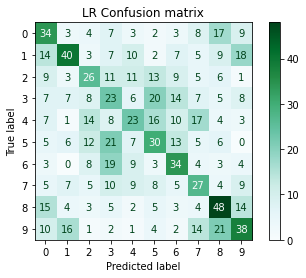

In [10]:
print(accuracy_score(y_test_sample, final_pred))
plot_confusionMatrix(y_test_sample, final_pred, title='LR Confusion matrix')

* Logistic regression model resulted in higher accuracy = 32%
* Also, the confusion matrix shows that the model is not biased to any class like the KNN

## Part 3. Support Vector Machine (SVM) Classification (4 Marks)

In Part 3. you will use Scikit-learn to perform classification, again on the Cifar10 dataset. You can use the built in SVM library for classification. As with logistic regression, SVM is designed for binary classification. However, in this case Scikit-learn will handle the OvR models behind the scenes.

Your task is to compare different modes of the SVM and determine the best performer. 

Create an SVM baseline using the <code>LinearSVC()</code> function. Make sure to use the primal solution and use "ovr" for multiclass Calculate the accuracy score for comparison.

Next you will explore the effect of the cost parameter on the accuracy.
    <ul>
    <li>Run the classification with a range of C values For example: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]</li>
    <li>Plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>

Add a regularization term.
    <ul>
    <li>Rerun the above experiment, but this time use L1 regularization.</li>
    <li>Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>

For the final experiment you will use the ```SVC()``` function to run the classifer with a kernel.
    <ul>
    <li>Use a radial basis function when training a new model</li>
    <li>Find the optimal combination of values for the cost and gamma parameters. Use the following values in your loop:<br/>
        <div style="margin-left:40px"><code>
        for cost in [0.01, 0.1, 1, 10, 100]:<br/>
        &emsp;for gamma in [0.01, 0.1, 1, 10, 100]:
        </code></div>
    </li>
    <li>Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>


Choose the model with the highest accuracy and plot the confusion matrix. In your discussion explain the results of your experiments and the reason for increased performance from the baseline (if any). Comment on the effect of the cost-paramenter and the L1 penalty on accuracy as well as any overfitting you observed. Discuss the confusion matrix of the model accuracy and provide some reasons for high-values found off the main diagonal.

### Bonus Mark
Instead of using raw pixel values compute an alternate feature representation for your dataset and re-run train the model. Compare the accuracy of the model using the new feature representation with the model trained with pixel values.

In [17]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [18]:
def log_plot(c_values, accuracies, title):
  plt.xscale("log")
  plt.title(title)
  plt.xlabel('C values')
  plt.ylabel('Accuracy')
  plt.plot(c_values, accuracies)
  plt.show()

### Base

In [20]:
# Base model

t =time.time()
base_svm = LinearSVC(random_state=0, multi_class='ovr')
base_svm.fit(x_sample.reshape(10000, -1)/255, y_sample)

print((time.time()-t), "Seconds")

base_pred = base_svm.predict(x_test_sample.reshape(x_test_sample.shape[0], -1)/255)
acc = accuracy_score(y_test_sample, base_pred)
print(f"accuracy of base model = {acc}")

545.5386748313904 Seconds
accuracy of base model = 0.263


C:\Users\Sarah\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Convergence behavior can be compared, often in terms of the number of iterations of an algorithm required until convergence, to the objective function evaluation of the stable point found at convergence, and combinations of these concerns.

[source](https://machinelearningmastery.com/premature-convergence/#:~:text=Addressing%20Premature%20Convergence-,Convergence%20in%20Machine%20Learning,when%20working%20with%20optimization%20algorithms.)

### Linear model tuning

In [11]:
# Cost & Regulaization tuning

c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]
# SVC expriment
def svc_tuning(reg = False):
  a = []
  if reg:
      for c in tqdm.notebook.tqdm(c_values):
        clf = LinearSVC(C = c, penalty="l1", dual=False, random_state=0)
        clf.fit(x_sample.reshape(x_sample.shape[0], -1), y_sample)
        y_pred = clf.predict(x_test_sample.reshape(x_test_sample.shape[0], -1))
        a.append(accuracy_score(y_test_sample, y_pred))
      return a

  else:
    for c in tqdm.notebook.tqdm(c_values):
      clf = LinearSVC(C = c, random_state=0)
      clf.fit(x_sample.reshape(x_sample.shape[0], -1), y_sample)
      y_pred =  clf.predict(x_test_sample.reshape(x_test_sample.shape[0], -1))
      a.append(accuracy_score(y_test_sample, y_pred))
    return a

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

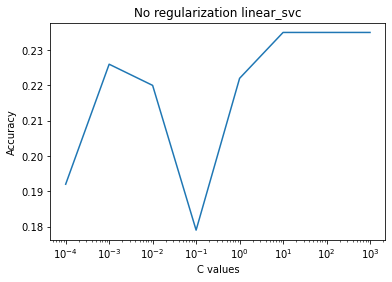

In [ ]:
accuracies = svc_tuning(reg = False)
log_plot(c_values, accuracies, 'No regularization linear_svc')

  0%|          | 0/8 [00:00<?, ?it/s]

/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinea

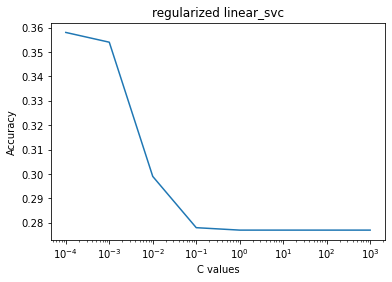

In [12]:
accuracies = svc_tuning(reg = True)
log_plot(c_values, accuracies, 'regularized linear_svc')

### RBF

In [10]:
c_values = [0.01, 0.1, 1, 10, 100]
gamma_values = [0.01, 0.1, 1, 10, 100]

def svc_rbf_tuning():

  highest_acc = {'c':0, 'gamma':0, 'value':0, 'y_pred':[]}

  for gamma in (gamma_values):
    a = []
    for c in tqdm.notebook.tqdm(c_values):
      clf = SVC(C = c, kernel = 'rbf', gamma= gamma)
      clf.fit(x_sample.reshape(x_sample.shape[0], -1)/255, y_sample)
      y_pred =  clf.predict(x_test_sample.reshape(x_test_sample.shape[0], -1)/255)

      a.append(accuracy_score(y_test_sample, y_pred))

      #Store the best results so far to display the confusion matrix later
      if a[-1] > highest_acc['value']:
        highest_acc.update({'c':c, 'gamma':gamma, 'value': a[-1], 'y_pred': y_pred})

    log_plot(c_values, a, f'C vs Accuracy for Gamma = {gamma}')

  return highest_acc

  0%|          | 0/5 [00:00<?, ?it/s]

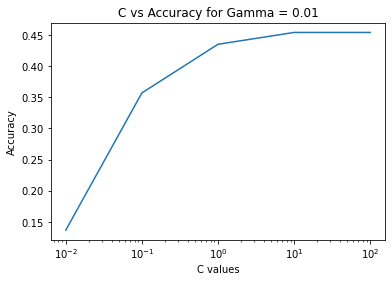

  0%|          | 0/5 [00:00<?, ?it/s]

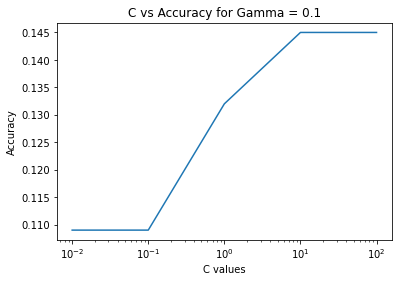

  0%|          | 0/5 [00:00<?, ?it/s]

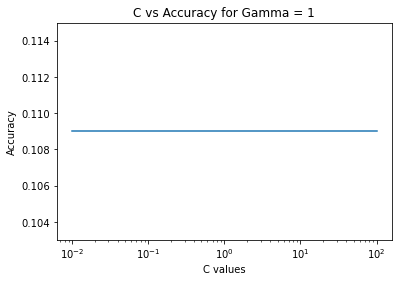

  0%|          | 0/5 [00:00<?, ?it/s]

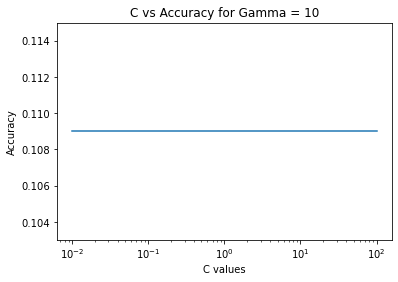

  0%|          | 0/5 [00:00<?, ?it/s]

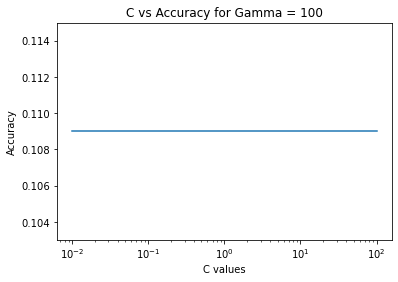

In [11]:
highest_acc = svc_rbf_tuning()

Highest accuracy = , 0.454%
Gamma = 0.01 & C = 10


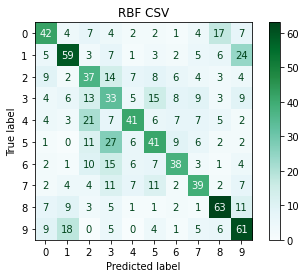

In [16]:
print(f"Highest accuracy = , {highest_acc['value']}%\nGamma = {highest_acc['gamma']} & C = {highest_acc['c']}")
plot_confusionMatrix(y_test_sample, highest_acc['y_pred'], title='RBF CSV')

## Part 4. Write a Conclusion

The following table summarize the results:

Model | KNN-Euclidean | KNN-Manhattan | LR | svm-l2(c=1) | SVM-l2(c=10) | svm-L1(c=0.0001) |gamma
--- | --- | --- | --- |--- |--- |--- |--- 
Accuracy(%) | 23.6 | 23.4 | 32.3 | 26.3 | 24 | 36 | 45.4  

---

Machine learning algorithms are not suitable for image analysis problems, as they do not put into consideration the pixels' locations and the neighbouring pixels
* **KNN:** resulted in the lowest accuracies in both Euclidean & Manhattan distances, as it was biased to a class.
* **LR:** Achieved higher accuracy.
---
*SVM Models*
* **SVM-L2-(C=1)**: 
   * Which is the base model for SVM models achieved 26%
   * L2 penalty performed better with large values of C, in contrast with L1
   
   * None Linear SVM model achieved the highest accuracy as expected because the decision boundary is expected to be complex.